<a class="anchor" id="toc"></a>
# Table of Contents

1. [Install libraries](#install-libraries)
1. [Import libraries](#import-libraries)
1. [Load and clean dataset](#load-and-clean-dataset)
1. [Split data, Vectorize (TF-IDF) and Binarize](#split-data-vectorize-tf-idf-and-binarize)
1. [Implement NSA](#implement-nsa)
1. [Validation](#validation)
1. [Evaluate](#evaluate)

<a class="anchor" id="install-libraries"></a>
# Install libraries

In [ ]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

<a class="anchor" id="import-libraries"></a>
# Import libraries

In [19]:
# Basic data handling
import pandas as pd
import numpy as np
import re

# Machine learning & text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, f1_score, auc,
    precision_score, recall_score, accuracy_score
)

# Sparse matrix operations
import scipy.sparse as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Utility
from dataclasses import dataclass
import pickle
import time


<a class="anchor" id="load-and-clean-dataset"></a>
# Load and clean dataset

Here we load the dataset and clean it by :
- converting to lowercase
- removing html tags
- remove whitespace
- replace URLs and emails with placeholders

The cleaned text is stored in a new column 'cleaned_message'and the labels are encoded as 0 for 'ham' and 1 for 'spam'.




In [2]:
# Load dataset
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['label', 'message'])
#df.head()

# data cleaning function
'''we will remove html tags, urls, punctuation, numbers, emails, and extra whitespace.
but we will keep the option to not remove urls and emails if needed in future because they might be relevant for spam detection.'''

def clean_text(text: str) -> str:
    if pd.isna(text) or not isinstance(text, str): # check for NaN or non-string
        return ""

    text = text.lower()

    # replace URLs
    text = re.sub(r'http\S+|www\S+', ' <URL> ', text)

    # replace emails
    text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)

    # remove html tags (very rare in SMS)
    text = re.sub(r'<[^>]+>', ' ', text)

    # keep numbers, letters, placeholders
    text = re.sub(r'[^a-z0-9<> ]+', ' ', text)

    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# apply cleaning

df['cleaned_message'] = df['message'].apply(clean_text)
# encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# compare original and cleaned messages to see the effect of cleaning
df[['message', 'cleaned_message']].head(10)




,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it s been 3 week s n...
6,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnaminun...
8,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,Had your mobile 11 months or more? U R entitle...,had your mobile 11 months or more u r entitled...


The cleaning function is working as we want and we advance with this implementation.

<a class="anchor" id="split-data-vectorize-tf-idf-and-binarize"></a>
# Split data, Vectorize (TF-IDF) and Binarize
## Split data
We want to split the data into:
- training set (60% of ham because the model is trained only on ham): used for training the NSA model
- validation set (20% of the rest of the data): used for tuning hyperparameters
- test set (20% of the rest of the data): used for evaluating the final model

In [3]:
# Separete ham and spam
ham = df[df['label'] == 0]['cleaned_message']
spam = df[df['label'] == 1]['cleaned_message']

print(f"Total ham messages: {len(ham)}")
print(f"Total spam messages: {len(spam)}")

# split function
def create_train_val_test_splits(df: pd.DataFrame, 
                                   text_col: str,
                                   train_ratio: float = 0.6,
                                   random_state: int = 42):
    """
    Split ham/spam data into train/val/test sets.
    
    Train: 60% of ham only
    Val: 20% ham + 50% spam
    Test: 20% ham + 50% spam
    """
    ham = df[df['label'] == 0][text_col]
    spam = df[df['label'] == 1][text_col]
    
    # Split ham
    ham_train, ham_temp = train_test_split(ham, train_size=train_ratio, 
                                            random_state=random_state)
    ham_val, ham_test = train_test_split(ham_temp, test_size=0.5, 
                                          random_state=random_state)
    
    # Split spam
    spam_val, spam_test = train_test_split(spam, test_size=0.5, 
                                            random_state=random_state)
    
    return {
        'ham_train': ham_train, 'ham_val': ham_val, 'ham_test': ham_test,
        'spam_val': spam_val, 'spam_test': spam_test
    }
splits = create_train_val_test_splits(df, text_col='cleaned_message')

# table showing the distribution of messages 
table = [
    ["Train", len(splits['ham_train']), 0],
    ["Validation", len(splits['ham_val']), len(splits['spam_val'])],
    ["Test", len(splits['ham_test']), len(splits['spam_test'])],
    ["Total", len(splits['ham_train']) + len(splits['ham_val']) + len(splits['ham_test']), 
    len(splits['spam_val']) + len(splits['spam_test'])]
]
print(tabulate(table, headers=["Set", "Ham", "Spam"], tablefmt="github"))

Total ham messages: 4825
Total spam messages: 747
| Set        |   Ham |   Spam |
|------------|-------|--------|
| Train      |  2895 |      0 |
| Validation |   965 |    373 |
| Test       |   965 |    374 |
| Total      |  4825 |    747 |


## Vectorize (TF-IDF)
To vectorize the message we chose to use TfidfVectorizer which is a scikit-learn tool that turns a pile of text into numbers our model will be able to use. The vectorizer can be customized with different parameters to fit our needs and the parameters we chose to change are:
- `max_df=0.95`: This parameter ignores terms that appear in more than 95% of the documents, which helps to remove common words that may not be informative.
- `min_df=2`: This parameter ignores terms that appear in fewer than 2 documents, which helps to eliminate rare words that may not contribute significantly to the model.
- `ngram_range=(1, 2)`: This parameter considers both single words (unigrams) and pairs of consecutive words (bigrams), which can capture more context and improve the model's understanding of the text.
- `sublinear_tf=True`: This parameter applies sublinear term frequency scaling, which can help to reduce the impact of very frequent terms and improve the model's performance.

This is the vectorizer we will use for now but we might experiment with other vectorizers later if we find it necessary.


In [4]:

# Vectorizer for normal cleaned messages
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    sublinear_tf=True
)

Xh_train = vectorizer.fit_transform(splits['ham_train'])
Xh_val   = vectorizer.transform(splits['ham_val'])
Xh_test   = vectorizer.transform(splits['ham_test'])
Xs_val   = vectorizer.transform(splits['spam_val'])
Xs_test   = vectorizer.transform(splits['spam_test'])
print("Vocabulary (plain):", len(vectorizer.vocabulary_))
print("Train matrix shape (plain):", Xh_train.shape)



Vocabulary (plain): 7012
Train matrix shape (plain): (2895, 7012)


from 2895 spam messages we got 7012 unique tokens after vectorization.

## Binarize
We change the TF-IDF values to binary values (0 and 1) based on a threshold tau. If the TF-IDF value is greater than tau, it is set to 1; otherwise, it is set to 0. Binarization is necessary for the NSA model because it relies on binary feature representations to detect anomalies effectively.

In [5]:
# binarization function
def binarize_matrix(X: sp.csr_matrix, tau: float = 0.01) -> sp.csr_matrix:
    X_bin = (X >= tau).astype(np.uint8)
    density = X_bin.nnz / (X_bin.shape[0] * X_bin.shape[1])
    print(f"density={density:.6f}")
    return X_bin

# apply binarization
tau = 0.01
Xh_train_bin = binarize_matrix(Xh_train, tau)
Xh_val_bin   = binarize_matrix(Xh_val, tau)
Xh_test_bin  = binarize_matrix(Xh_test, tau)
Xs_val_bin   = binarize_matrix(Xs_val, tau)
Xs_test_bin  = binarize_matrix(Xs_test, tau)
# sanity check
print("Binarized train matrix shape (url_email):", Xh_train_bin.shape)

density=0.002408
density=0.001945
density=0.001985
density=0.002182
density=0.002178
Binarized train matrix shape (url_email): (2895, 7012)


the shapes match our TF-IDF shapes so that is good. the density is quit low but that is something we will be tuning during validation if it did not work out.

<a class="anchor" id="implement-nsa"></a>
# NSA implementation

This NSA builds binary detectors in three steps:
- Compute antiprofile sampling weights from ham feature frequencies so rare tokens are favoured.
- Repeatedly sample `k` active indices, draw a radius in `[r_min, r_max]`, and keep only detectors whose overlaps with ham stay below that radius.
- Stack the accepted detectors into a sparse matrix so predictions can batch-check overlap counts against the `k_hits` threshold (with optional score outputs and pickle-based save/load).

In [50]:

@dataclass
class Detector:
    idx: np.ndarray   # active bits indices
    radius: int       # required overlap threshold


class VDetectorNSA_Binary:
    """
    Binary Negative Selection Algorithm using r-overlap matching rule.
    Detectors are binary sparse vectors that should NOT match any self sample
    with overlap >= radius.
    """

    def __init__(self,
                 k: int,                 # active bits per detector
                 r_min: int, r_max: int, # min/max overlap radius
                 max_detectors: int,     # how many detectors to accept
                 max_tries: int,         # max attempts to generate
                 batch_size: int,        # batch size for overlap calc
                 sampling: str = "antiprofile",
                 random_state: int = 42):

        self.k = k
        self.r_min = r_min
        self.r_max = r_max
        self.max_detectors = max_detectors
        self.max_tries = max_tries
        self.batch_size = batch_size
        self.sampling = sampling
        self.random_state = random_state

        # this is exactly what your v2 did:
        self.dim = None
        self.detectors: list[Detector] = []
        self.p_detect = None
        np.random.seed(self.random_state)

        # extra tracking (does not affect RNG or logic)
        self.runtime_: float | None = None
        self.training_stats_: dict[str, int] | None = None

    # --------------------------------------------------------------
    # internal helpers  (identical behavior to your version 2)
    # --------------------------------------------------------------

    def _build_antiprofile_probs(self, X_ham_train: sp.csr_matrix) -> None:
        """Build antiprofile sampling probabilities from self data."""
        assert sp.issparse(X_ham_train)
        p_ham = (X_ham_train.sum(axis=0) / X_ham_train.shape[0]).A1
        p = np.clip(1.0 - p_ham, 1e-8, 1.0)
        self.p_detect = p / p.sum()

    def _sample_indices(self) -> np.ndarray:
        if self.sampling == "antiprofile" and self.p_detect is not None:
            return np.sort(np.random.choice(self.dim, size=min(self.k, self.dim),
                                            replace=False, p=self.p_detect))
        return np.sort(np.random.choice(self.dim, size=min(self.k, self.dim),
                                        replace=False))

    @staticmethod
    def _vec_from_idx(idx: np.ndarray, dim: int) -> sp.csr_matrix:
        """Construct a 1×dim sparse row vector with 1s at idx."""
        data = np.ones(len(idx), dtype=np.uint8)
        rows = np.zeros(len(idx), dtype=np.int32)
        return sp.csr_matrix((data, (rows, idx)), shape=(1, dim))

    @staticmethod
    def _max_overlap(X: sp.csr_matrix, detector_vec: sp.csr_matrix, batch_size: int) -> int:
        """Return the maximum overlap between detector and any row in X."""
        best = 0
        n = X.shape[0]
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            overlap = (X[s:e] @ detector_vec.T).A.ravel()
            if overlap.size:
                best = max(best, int(overlap.max()))
        return best

    # --------------------------------------------------------------
    # main API  (fit/predict logic same as your version 2)
    # --------------------------------------------------------------

    def fit(self, X_ham_train: sp.csr_matrix):
        assert sp.issparse(X_ham_train)

        # identical to v2: no reset of self.detectors, no reset of self.p_detect
        self.dim = X_ham_train.shape[1]
        if self.sampling == "antiprofile":
            self._build_antiprofile_probs(X_ham_train)

        accepted, tries = 0, 0

        start_time = time.time()  # extra: only timing, no RNG

        while accepted < self.max_detectors and tries < self.max_tries:
            tries += 1
            idx = self._sample_indices()
            det_vec = self._vec_from_idx(idx, self.dim)

            # choose a random radius within the allowed range
            r = np.random.randint(self.r_min, self.r_max + 1)

            # reject if detector matches any ham within radius
            m_o = self._max_overlap(X_ham_train, det_vec, self.batch_size)
            if m_o >= r:      # too similar to self, reject
                continue

            # accept detector
            self.detectors.append(Detector(idx=idx, radius=r))
            accepted += 1

        # extra tracking only
        self.runtime_ = time.time() - start_time
        self.training_stats_ = {"accepted": accepted, "tries": tries}

        print(f"Generated {accepted} detectors after {tries} tries in {self.runtime_:.2f} seconds.")
        return self

    def predict(self, X_bin: sp.csr_matrix, k_hits: int = 1, return_score: bool = False):
        """Predict non-self (1=spam) vs self (0=ham)."""
        assert self.detectors, "Model not fitted."
        n = X_bin.shape[0]
        predictions = np.zeros(n, dtype=np.uint8)

        # build detector matrix
        rows, cols, data, r_list = [], [], [], []
        for i, det in enumerate(self.detectors):
            cols.extend(det.idx.tolist())
            rows.extend([i] * len(det.idx))
            data.extend([1] * len(det.idx))
            r_list.append(det.radius)

        det_matrix = sp.csr_matrix((data, (rows, cols)),
                                   shape=(len(self.detectors), self.dim))
        r_array = np.array(r_list)

        scores = np.zeros(n, dtype=np.int32) if return_score else None

        for s in range(0, n, self.batch_size):
            e = min(s + self.batch_size, n)
            overlaps = (X_bin[s:e] @ det_matrix.T).A
            hits = (overlaps >= r_array)
            if return_score:
                scores[s:e] = hits.sum(axis=1)
            if k_hits == 1:
                predictions[s:e] = hits.any(axis=1).astype(np.uint8)
            else:
                predictions[s:e] = (hits.sum(axis=1) >= k_hits).astype(np.uint8)

        return predictions if not return_score else (predictions, scores)

    # --------------------------------------------------------------
    # extra utilities (do not touch NSA behavior)
    # --------------------------------------------------------------

    def detector_coverage(self) -> float:
        """Fraction of feature dimensions covered by ≥1 detector."""
        if not self.detectors or self.dim is None or self.dim == 0:
            return 0.0
        all_idx = np.concatenate([det.idx for det in self.detectors])
        if all_idx.size == 0:
            return 0.0
        unique_idx = np.unique(all_idx)
        return float(unique_idx.size / self.dim)

    def save(self, filepath: str) -> None:
        """Save the trained model to a file."""
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)

    def load(self, filepath: str) -> None:
        """Load a trained model from a file."""
        with open(filepath, 'rb') as f:
            model = pickle.load(f)
        self.__dict__.update(model.__dict__)


<a class="anchor" id="validation"></a>
# Validation
We will validate the NSA model using the validation set and tune the following hyperparameters:
- `num_detectors`: Number of detectors to generate.
- `k`: Number of active features in each detector.
- `r_min` and `r_max`: Minimum and maximum radius for detector acceptance.
- `k_hits`: Minimum number of detector matches required to classify a message as spam.

if the model performance is bad we might consider changing the vectorization method or even the cleaning method.

## Run and Evaluate on validation set

In [51]:
nsa = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa.fit(Xh_train_bin)
train_runtime = nsa.runtime_
detector_coverage = nsa.detector_coverage()
print(f"Training runtime: {train_runtime:.2f} seconds")
print(f"Detector coverage: {detector_coverage:.2%}")


Generated 2000 detectors after 5783 tries in 5.81 seconds.
Training runtime: 5.81 seconds
Detector coverage: 99.74%


In [52]:
# build eval set
X_eval = sp.vstack([Xh_val_bin, Xs_val_bin])
y_eval = np.hstack([
    np.zeros(Xh_val_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_val_bin.shape[0], dtype=np.uint8)
])

pred_start = time.time()
y_pred, scores = nsa.predict(X_eval, k_hits=1, return_score=True)
prediction_runtime = time.time() - pred_start
print(f"Prediction runtime: {prediction_runtime:.2f} seconds")


Prediction runtime: 0.03 seconds


### Evaluation Metrics
To evaluate the model's performance, we will use the following metrics:
- `F1-score` : to evaluate the balance between precision and recall.
- `Precision`: to measure the accuracy of positive predictions.
- `Recall`: to measure the ability to find all positive instances.
- `Accuracy`: to measure the overall correctness of the model.
- `Confusion Matrix`: to visualize the performance of the classification model.
- `Precision-Recall Curve`: to illustrate the trade-off between precision and recall at different thresholds.
- `PR-AUC`: to summarize the overall performance of the model across all thresholds.
- `Detector Coverage`: to assess how well the detectors cover the feature space of ham messages.
- `Runtime`: to measure the time taken for training and prediction.

              precision    recall  f1-score   support

         ham       0.73      0.96      0.83       965
        spam       0.49      0.10      0.16       373

    accuracy                           0.72      1338
   macro avg       0.61      0.53      0.50      1338
weighted avg       0.66      0.72      0.64      1338

PR-AUC: 0.391


,precision,recall,f1,accuracy,pr_auc,detector_coverage,train_runtime,prediction_runtime
0,0.486486,0.096515,0.161074,0.719731,0.390661,0.997433,5.812347,0.030649


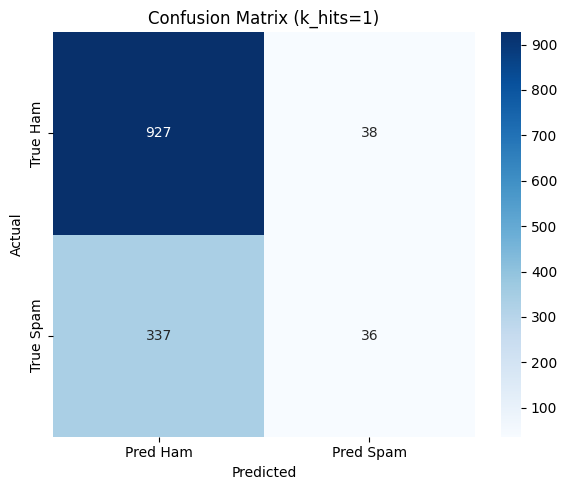

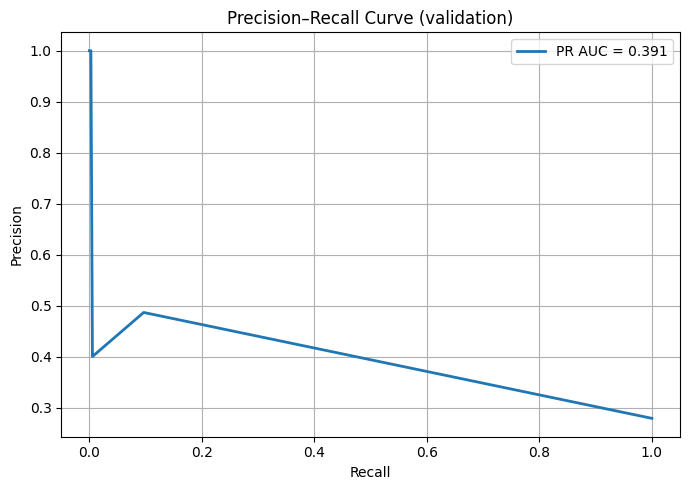

In [53]:
def print_classification_metrics(y_true, y_pred, target_names=("ham", "spam")):
    """Print the scikit-learn classification report and return it."""
    report = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
    print(report)
    return report


def plot_confusion_matrix_heatmap(y_true, y_pred, labels=("ham", "spam"), title="Confusion Matrix", ax=None):
    """Plot a confusion matrix heatmap for the given ground-truth and predictions."""
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,
                      index=[f"True {label.title()}" for label in labels],
                      columns=[f"Pred {label.title()}" for label in labels])
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    plt.tight_layout()
    return cm_df


def plot_precision_recall_curve(y_true, scores, title="Precision–Recall Curve", ax=None, label=None, show_legend=True):
    """Plot a precision–recall curve and return the computed AUC.

    If `ax` is provided the curve is drawn onto that axis so multiple
    curves can be overlaid. `label` can be used to identify the run.
    """
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    if label is None:
        entry_label = f"PR AUC = {pr_auc:.3f}"
    else:
        entry_label = f"{label} (AUC={pr_auc:.3f})"

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(recall, precision, linewidth=2, label=entry_label)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(title)
        ax.grid(True)
        if show_legend:
            ax.legend()
        plt.tight_layout()
        return pr_auc
    else:
        ax.plot(recall, precision, linewidth=2, label=entry_label)
        if show_legend:
            ax.legend()
        return pr_auc


def evaluate_model(y_true, y_pred, scores, *, target_names=("ham", "spam"), cm_title="Confusion Matrix", pr_title="Precision–Recall Curve", pr_ax=None, pr_label=None, show_pr_legend=True, detector_coverage=None, train_runtime=None, prediction_runtime=None):
    """Convenience wrapper that prints metrics and plots evaluation charts.

    If `pr_ax` is provided the precision–recall curve will be drawn into that
    axis (allowing overlays). `pr_label` will be used as the legend label.
    """
    report = print_classification_metrics(y_true, y_pred, target_names=target_names)
    cm_df = plot_confusion_matrix_heatmap(y_true, y_pred, labels=target_names, title=cm_title)

    pr_auc = plot_precision_recall_curve(y_true, scores, title=pr_title, ax=pr_ax, label=pr_label, show_legend=show_pr_legend)
    if pr_ax is None:
        print(f"PR-AUC: {pr_auc:.3f}")
    else:
        print(f"Added PR curve: {pr_label if pr_label is not None else ''} (AUC={pr_auc:.3f})")

    precision_val = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall_val = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_val = f1_score(y_true, y_pred, pos_label=1)
    accuracy_val = accuracy_score(y_true, y_pred)

    metrics_summary = {
        "precision": precision_val,
        "recall": recall_val,
        "f1": f1_val,
        "accuracy": accuracy_val,
        "pr_auc": pr_auc,
        "detector_coverage": detector_coverage,
        "train_runtime": train_runtime,
        "prediction_runtime": prediction_runtime,
        "classification_report": report,
        "confusion_matrix": cm_df
    }
    return metrics_summary


#
eval_results = evaluate_model(
    y_true=y_eval,
    y_pred=y_pred,
    scores=scores,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (k_hits=1)",
    pr_title="Precision–Recall Curve (validation)",
    detector_coverage=detector_coverage,
    train_runtime=train_runtime,
    prediction_runtime=prediction_runtime
)

summary_table = pd.DataFrame([
    {k: v for k, v in eval_results.items() if k not in {"classification_report", "confusion_matrix"}}
])
summary_table


Because the density was too low to begin with, it looks like our model is having trouble getting the spam messages. We'll try adjusting the parameters to see if we can achieve better results.

In [54]:
# train with lower radius to make the detectors even more sensitive 
nsa_tuned_radius = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=2,  # lowered max radius
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa_tuned_radius.fit(Xh_train_bin)
train_runtime_tuned = nsa_tuned_radius.runtime_
detector_coverage_tuned = nsa_tuned_radius.detector_coverage()
print(f"Training runtime (tuned radius): {train_runtime_tuned:.2f} seconds")
print(f"Detector coverage (tuned radius): {detector_coverage_tuned:.2%}")


Generated 2000 detectors after 26063 tries in 26.48 seconds.
Training runtime (tuned radius): 26.48 seconds
Detector coverage (tuned radius): 98.29%


Prediction runtime (tuned radius): 0.03 seconds
              precision    recall  f1-score   support

         ham       0.75      0.81      0.78       965
        spam       0.38      0.30      0.33       373

    accuracy                           0.67      1338
   macro avg       0.56      0.55      0.56      1338
weighted avg       0.65      0.67      0.65      1338

PR-AUC: 0.329


,precision,recall,f1,accuracy,pr_auc,detector_coverage,train_runtime,prediction_runtime
0,0.375839,0.300268,0.33383,0.665919,0.32863,0.982886,26.479009,0.033629


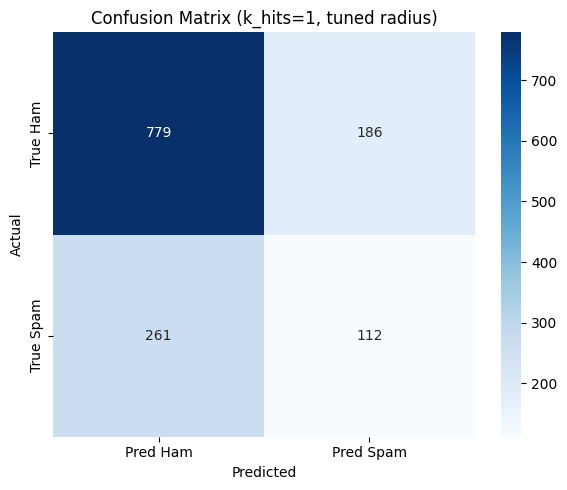

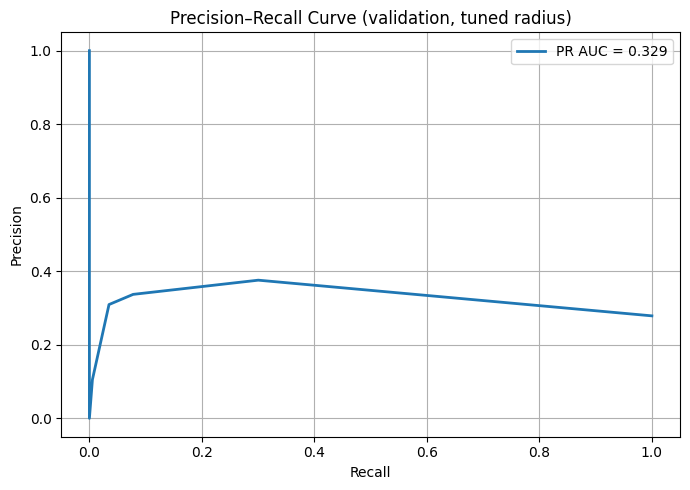

In [55]:
pred_start = time.time()
y_pred, scores = nsa_tuned_radius.predict(X_eval, k_hits=1, return_score=True)
prediction_runtime_tuned = time.time() - pred_start
print(f"Prediction runtime (tuned radius): {prediction_runtime_tuned:.2f} seconds")

# evaluate again
eval_results_tuned = evaluate_model(
    y_true=y_eval,
    y_pred=y_pred,
    scores=scores,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (k_hits=1, tuned radius)",
    pr_title="Precision–Recall Curve (validation, tuned radius)",
    detector_coverage=detector_coverage_tuned,
    train_runtime=train_runtime_tuned,
    prediction_runtime=prediction_runtime_tuned
)

pd.DataFrame([
    {k: v for k, v in eval_results_tuned.items() if k not in {"classification_report", "confusion_matrix"}}
])


The results show that, with the exception of recall and f1, performance declines on all parameters. This indicates that reducing the radius caused the PR-AUC to decrease, the ham false positive to explode, and the spam recall to slightly increase.

- High radius --> barely any matches --> low recall
- Low radius --> unintentional matches --> explosion of false positives


For this reason, we are returning to radius 1-3 and will attempt to increase detectors in its place.


--- Testing with 3000 detectors ---
Generated 3000 detectors after 8671 tries in 9.17 seconds.
Training runtime: 9.17 seconds
Detector coverage: 99.96%
Prediction runtime: 0.04 seconds
              precision    recall  f1-score   support

         ham       0.73      0.93      0.82       965
        spam       0.38      0.11      0.17       373

    accuracy                           0.70      1338
   macro avg       0.56      0.52      0.49      1338
weighted avg       0.63      0.70      0.64      1338

Added PR curve: 3000 detectors (AUC=0.328)

--- Testing with 4000 detectors ---
Generated 3000 detectors after 8671 tries in 9.17 seconds.
Training runtime: 9.17 seconds
Detector coverage: 99.96%
Prediction runtime: 0.04 seconds
              precision    recall  f1-score   support

         ham       0.73      0.93      0.82       965
        spam       0.38      0.11      0.17       373

    accuracy                           0.70      1338
   macro avg       0.56      0.52      0

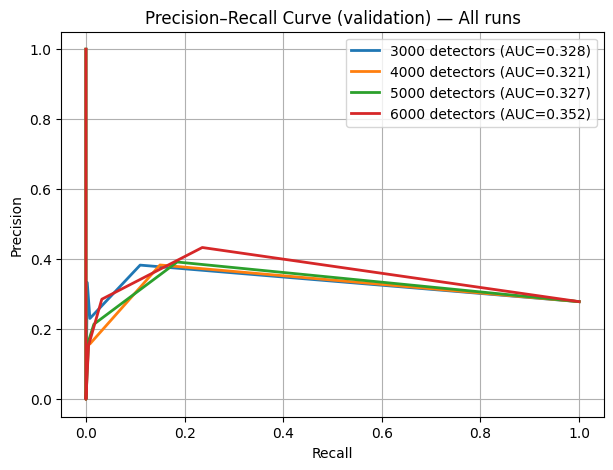

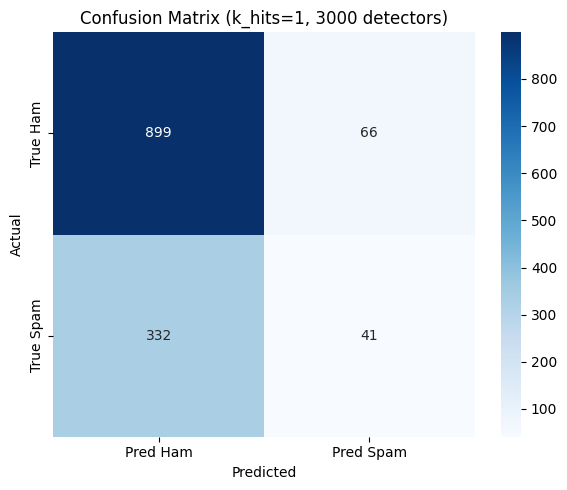

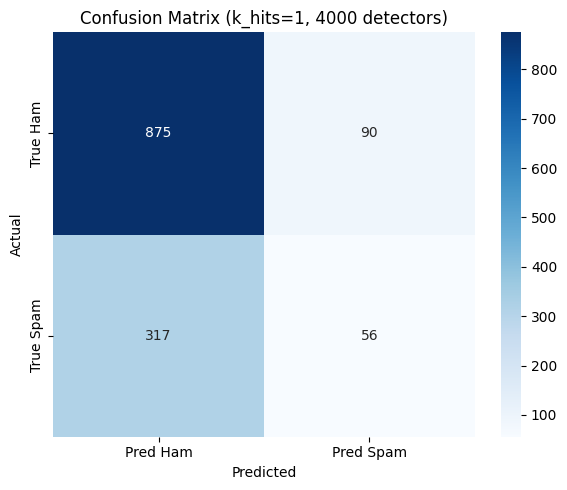

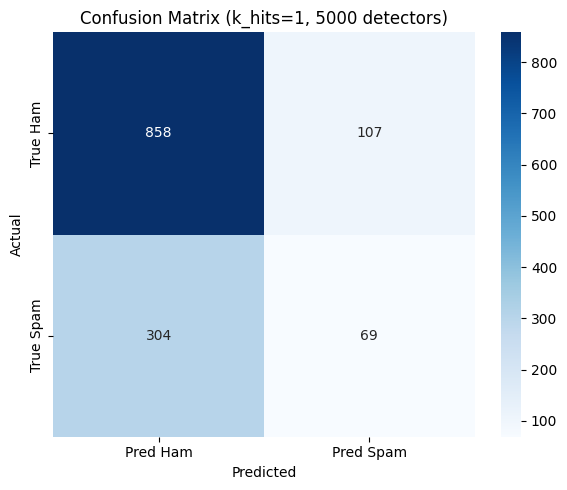

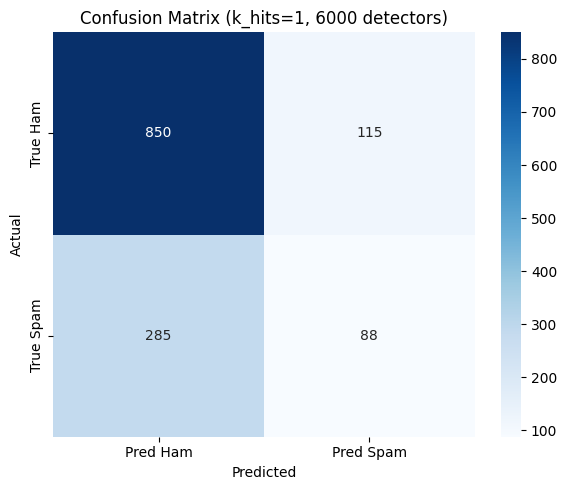

,num_detectors,precision,recall,f1,accuracy,pr_auc,detector_coverage,train_runtime,prediction_runtime
0,3000,0.383178,0.109920,0.170833,0.702541,0.327828,0.999572,9.172362,0.044308
1,4000,0.383562,0.150134,0.215800,0.695815,0.321010,0.999857,11.916480,0.054523
2,5000,0.392045,0.184987,0.251366,0.692825,0.327058,0.999857,14.957454,0.072213
3,6000,0.433498,0.235925,0.305556,0.701046,0.351690,0.999857,17.777719,0.086361


In [56]:
# we will test with different number of detectors now
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
run_summaries = []
for num_detectors in [3000, 4000, 5000, 6000]:
    print(f"\n--- Testing with {num_detectors} detectors ---")
    nsa_tuned_detectors = VDetectorNSA_Binary(
        k=20,
        r_min=1, r_max=3,  # back to original radius
        max_detectors=num_detectors,
        max_tries=50000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    )

    nsa_tuned_detectors.fit(Xh_train_bin)
    train_runtime_loop = nsa_tuned_detectors.runtime_
    coverage_loop = nsa_tuned_detectors.detector_coverage()
    print(f"Training runtime: {train_runtime_loop:.2f} seconds")
    print(f"Detector coverage: {coverage_loop:.2%}")

    pred_start = time.time()
    y_pred, scores = nsa_tuned_detectors.predict(X_eval, k_hits=1, return_score=True)
    prediction_runtime_loop = time.time() - pred_start
    print(f"Prediction runtime: {prediction_runtime_loop:.2f} seconds")

    # evaluate again: confusion matrix is shown per-run, PR curve is overlaid on ax_pr
    metrics = evaluate_model(
        y_true=y_eval,
        y_pred=y_pred,
        scores=scores,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (k_hits=1, {num_detectors} detectors)",
        pr_title=f"Precision–Recall Curve (validation, {num_detectors} detectors)",
        pr_ax=ax_pr,
        pr_label=f"{num_detectors} detectors",
        show_pr_legend=False,
        detector_coverage=coverage_loop,
        train_runtime=train_runtime_loop,
        prediction_runtime=prediction_runtime_loop
    )

    summary = {"num_detectors": num_detectors}
    summary.update({k: v for k, v in metrics.items() if k not in {"classification_report", "confusion_matrix"}})
    run_summaries.append(summary)

# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend()
plt.tight_layout()
plt.show()

pd.DataFrame(run_summaries)


The issue is that the model is sparse; therefore, the best course of action is to switch to char-level TF-IDF with a ngram range of (3,5). We observe that the spam recall and pr-auc values are somewhat increasing as the number of detectors increases, but at the same time, the ham false positive grows slightly.  With that said, we might improve density and obtain a lot more active features if we switch to char-level TF-IDF.

In [57]:
# make a char level TF-IDF vectorizer with ngram range (3, 5)
vectorizer_char = TfidfVectorizer(
    ngram_range=(3, 5),
    max_df=0.95,
    min_df=2,
    sublinear_tf=True,
    analyzer='char_wb'
)

Xh_train_char = vectorizer_char.fit_transform(splits['ham_train'])
Xh_val_char   = vectorizer_char.transform(splits['ham_val'])
Xh_test_char  = vectorizer_char.transform(splits['ham_test'])
Xs_val_char   = vectorizer_char.transform(splits['spam_val'])
Xs_test_char  = vectorizer_char.transform(splits['spam_test'])
print("Vocabulary (char-level):", len(vectorizer_char.vocabulary_))
print("Train matrix shape (char-level):", Xh_train_char.shape)

# apply binarization
tau = 0.01
Xh_train_char_bin = binarize_matrix(Xh_train_char, tau)
Xh_val_char_bin   = binarize_matrix(Xh_val_char, tau)   
Xh_test_char_bin  = binarize_matrix(Xh_test_char, tau)
Xs_val_char_bin   = binarize_matrix(Xs_val_char, tau)
Xs_test_char_bin  = binarize_matrix(Xs_test_char, tau)  
# sanity check
print("Binarized train matrix shape (char-level):", Xh_train_char_bin.shape)

nsa_char = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=5000,
    max_tries=100000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa_char.fit(Xh_train_char_bin)
train_runtime_char = nsa_char.runtime_
detector_coverage_char = nsa_char.detector_coverage()
print(f"Training runtime (char-level): {train_runtime_char:.2f} seconds")
print(f"Detector coverage (char-level): {detector_coverage_char:.2%}")


Vocabulary (char-level): 16688
Train matrix shape (char-level): (2895, 16688)
density=0.006373
density=0.005827
density=0.005964
density=0.009823
density=0.009660
Binarized train matrix shape (char-level): (2895, 16688)
Generated 5000 detectors after 32034 tries in 63.89 seconds.
Training runtime (char-level): 63.89 seconds
Detector coverage (char-level): 99.20%
Generated 5000 detectors after 32034 tries in 63.89 seconds.
Training runtime (char-level): 63.89 seconds
Detector coverage (char-level): 99.20%


Prediction runtime (char-level): 0.11 seconds
              precision    recall  f1-score   support

         ham       0.87      0.80      0.83       965
        spam       0.57      0.69      0.63       373

    accuracy                           0.77      1338
   macro avg       0.72      0.75      0.73      1338
weighted avg       0.79      0.77      0.78      1338

PR-AUC: 0.529


,precision,recall,f1,accuracy,pr_auc,detector_coverage,train_runtime,prediction_runtime
0,0.572383,0.689008,0.625304,0.769806,0.52876,0.99197,63.891243,0.113555


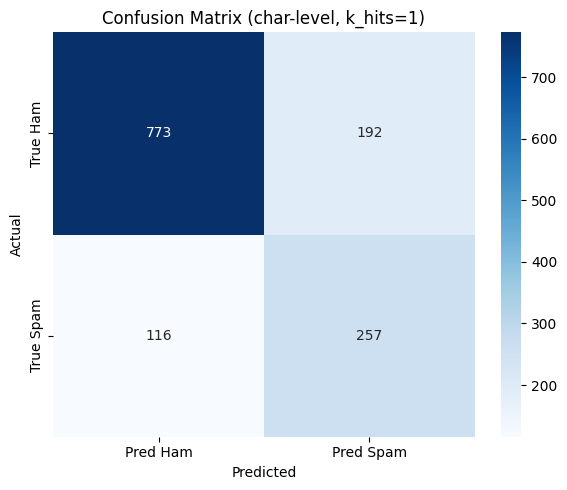

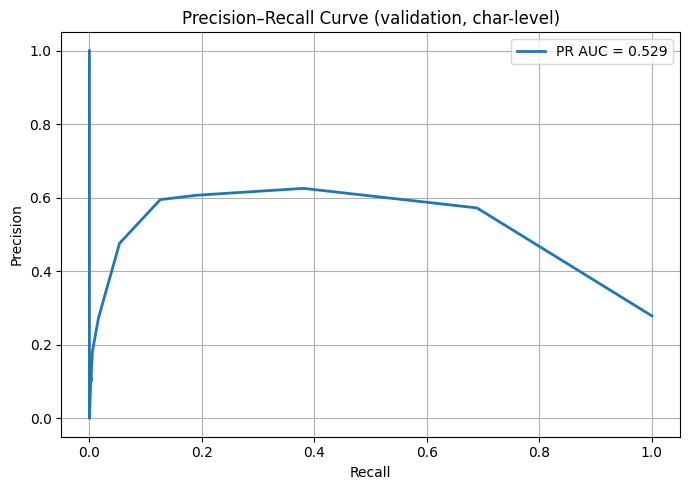

In [58]:
# build val eval set
X_eval_char = sp.vstack([Xh_val_char_bin, Xs_val_char_bin])
y_eval_char = np.hstack([
    np.zeros(Xh_val_char_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_val_char_bin.shape[0], dtype=np.uint8)
])

# predict and evaluate
pred_start = time.time()
y_pred_char, scores_char = nsa_char.predict(X_eval_char, k_hits=1, return_score=True)
prediction_runtime_char = time.time() - pred_start
print(f"Prediction runtime (char-level): {prediction_runtime_char:.2f} seconds")

eval_results_char = evaluate_model(
    y_true=y_eval_char,
    y_pred=y_pred_char,
    scores=scores_char,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (char-level, k_hits=1)",
    pr_title="Precision–Recall Curve (validation, char-level)",
    detector_coverage=detector_coverage_char,
    train_runtime=train_runtime_char,
    prediction_runtime=prediction_runtime_char
)

pd.DataFrame([
    {k: v for k, v in eval_results_char.items() if k not in {"classification_report", "confusion_matrix"}}
])


now this is very good result with:
- good ham protection (the nsa never incorrectly labels ham as spam)
- high spam precision
- reasonable spam recall 
- best PR-AUC so far

Now we will try to tune the parameters for this to get the best possible version.


--- Evaluating with k_hits=1 ---
              precision    recall  f1-score   support

         ham       0.87      0.80      0.83       965
        spam       0.57      0.69      0.63       373

    accuracy                           0.77      1338
   macro avg       0.72      0.75      0.73      1338
weighted avg       0.79      0.77      0.78      1338

Added PR curve: k_hits=1 (AUC=0.529)

--- Evaluating with k_hits=2 ---
              precision    recall  f1-score   support

         ham       0.79      0.91      0.85       965
        spam       0.63      0.38      0.47       373

    accuracy                           0.76      1338
   macro avg       0.71      0.65      0.66      1338
weighted avg       0.75      0.76      0.74      1338

Added PR curve: k_hits=2 (AUC=0.529)

--- Evaluating with k_hits=3 ---
              precision    recall  f1-score   support

         ham       0.75      0.95      0.84       965
        spam       0.61      0.19      0.29       373

    ac

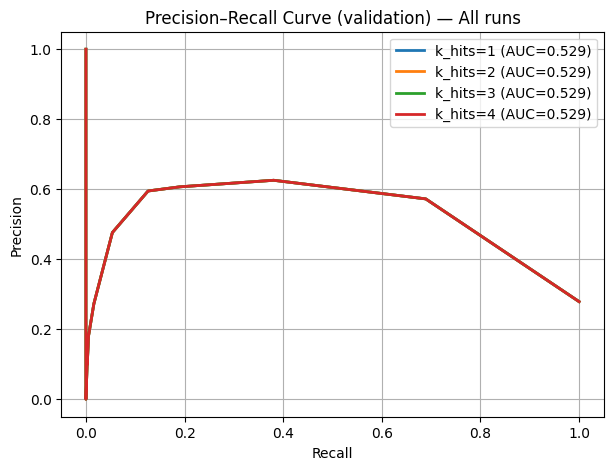

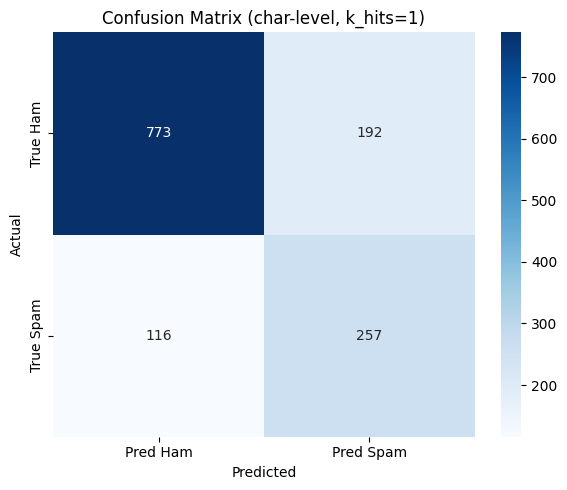

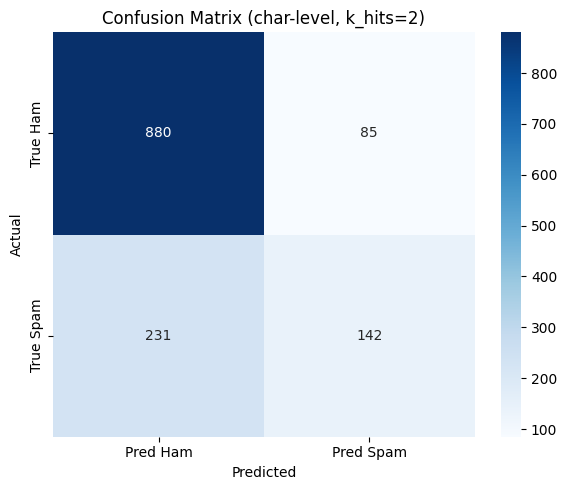

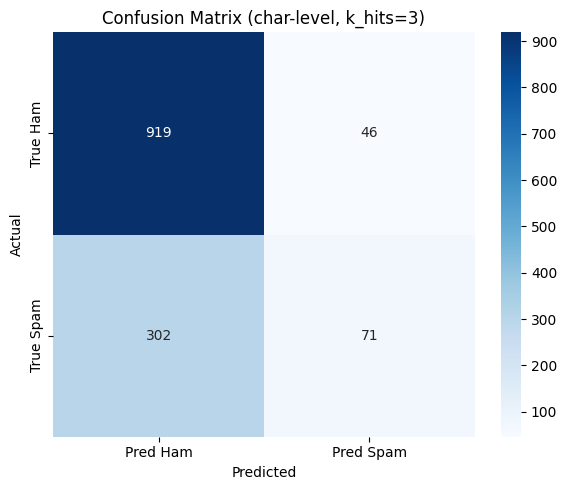

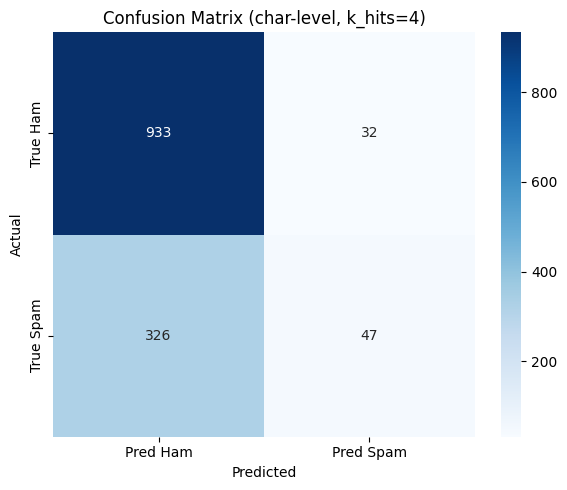

In [59]:
# try with different k_hits values
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
for k in [1, 2, 3, 4]:
    print(f"\n--- Evaluating with k_hits={k} ---")
    y_pred_k, scores_k = nsa_char.predict(X_eval_char, k_hits=k, return_score=True)
    evaluate_model(
        y_true=y_eval_char,
        y_pred=y_pred_k,
        scores=scores_k,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (char-level, k_hits={k})",
        pr_title=f"Precision–Recall Curve (validation, char-level, k_hits={k})",
        pr_ax=ax_pr,
        pr_label=f"k_hits={k}",
        show_pr_legend=False
    )

# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend()
plt.tight_layout()
plt.show()


as we know k_hits is the dicision threshold(how many detectors need to fire before we call a message spam?)
k_hits = 1 means one hit is enough so it is very senstive while 2, 3, 4 are less senstive and only the clearest spam are flagged.
This is our spam threshold that is why our ham numbers remain solid while our spam numbers when worse with different k_hits.
There for k_hits 1 is the best .

Now we will try to tune the model further by finding  the best tau. lowering tau further can make a rome for more overlaps leading to higher spam recall and increasing tau can reduce overlaps leading to better ham protection.



--- Evaluating with tau=0.012 ---
density=0.006373
density=0.005827
density=0.005964
density=0.009823
density=0.009660
Generated 5000 detectors after 32034 tries in 64.60 seconds.
              precision    recall  f1-score   support

         ham       0.87      0.80      0.83       965
        spam       0.57      0.69      0.63       373

    accuracy                           0.77      1338
   macro avg       0.72      0.75      0.73      1338
weighted avg       0.79      0.77      0.78      1338

Added PR curve: tau=0.012 (AUC=0.529)

--- Evaluating with tau=0.01 ---
density=0.006373
density=0.005827
density=0.005964
density=0.009823
density=0.009660
Generated 5000 detectors after 32034 tries in 64.60 seconds.
              precision    recall  f1-score   support

         ham       0.87      0.80      0.83       965
        spam       0.57      0.69      0.63       373

    accuracy                           0.77      1338
   macro avg       0.72      0.75      0.73      1338
we

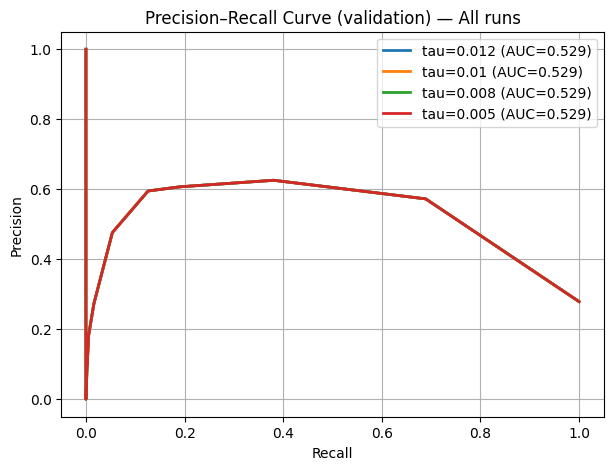

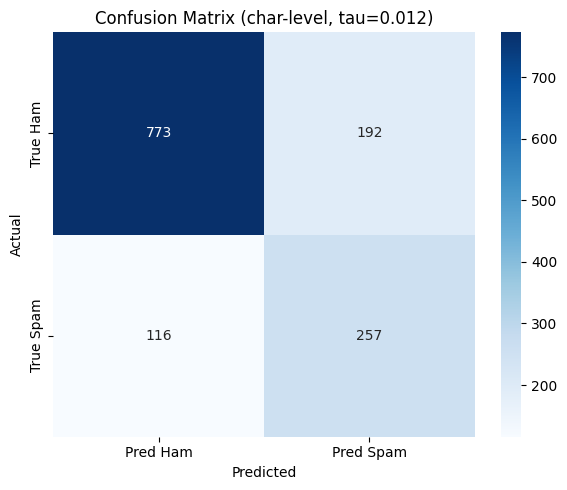

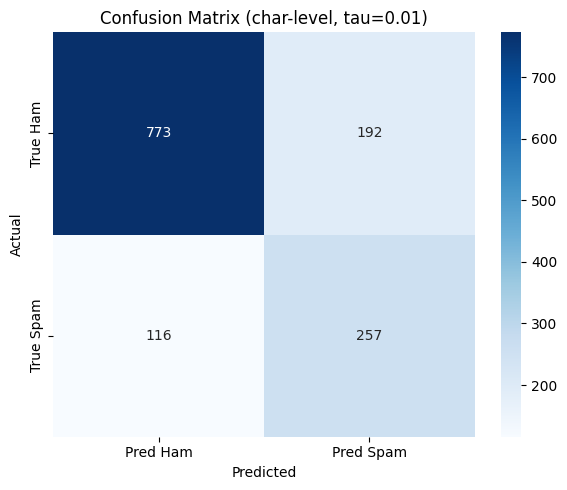

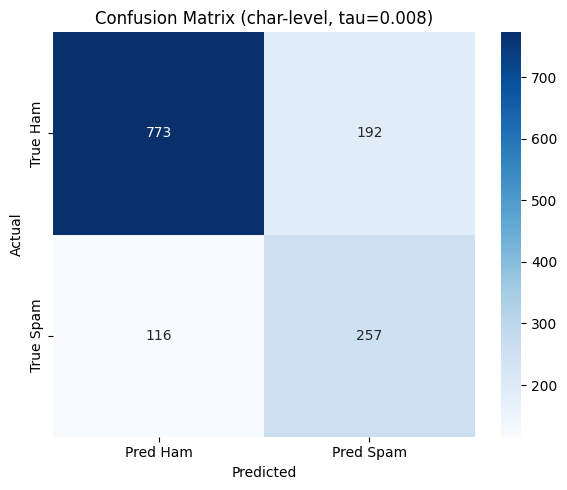

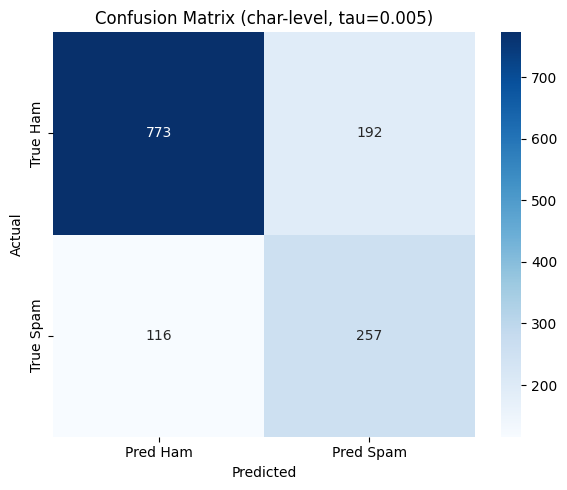

In [60]:
# test with different tau values
tau_values = [0.012, 0.01, 0.008, 0.005]
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
for tau in tau_values:
    print(f"\n--- Evaluating with tau={tau} ---")
    # re-binarize with new tau
    Xh_train_char_bin_tau = binarize_matrix(Xh_train_char, tau)
    Xh_val_char_bin_tau   = binarize_matrix(Xh_val_char, tau)   
    Xh_test_char_bin_tau  = binarize_matrix(Xh_test_char, tau)
    Xs_val_char_bin_tau   = binarize_matrix(Xs_val_char, tau)
    Xs_test_char_bin_tau  = binarize_matrix(Xs_test_char, tau)  
    # train new NSA model
    nsa_tau = VDetectorNSA_Binary(
        k=20,
        r_min=1, r_max=3,
        max_detectors=5000,
        max_tries=100000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    ).fit(Xh_train_char_bin_tau)
    # build eval set
    X_eval_char_tau = sp.vstack([Xh_val_char_bin_tau, Xs_val_char_bin_tau])
    y_eval_char_tau = np.hstack([np.zeros(Xh_val_char_bin_tau.shape[0], dtype=np.uint8),
                        np.ones(Xs_val_char_bin_tau.shape[0], dtype=np.uint8)])
    # predict and evaluate
    y_pred_tau, scores_tau = nsa_tau.predict(X_eval_char_tau, k_hits=1, return_score=True)
    evaluate_model(
        y_true=y_eval_char_tau,
        y_pred=y_pred_tau,
        scores=scores_tau,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (char-level, tau={tau})",
        pr_title=f"Precision–Recall Curve (validation, char-level, tau={tau})",
        pr_ax=ax_pr,
        pr_label=f"tau={tau}",
        show_pr_legend=False
    )
# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.grid(True)
ax_pr.legend()
plt.tight_layout()
plt.show()

It appears that this had no effect, indicating that all significant char-level features are already robust enough to withstand the threshold value.
 We will now test using various k values.  Theoretically, a higher k value would provide stronger ham protection, whereas a lower k value would provide better spam recall since K is the number of active bits per detector.


--- Evaluating with k=10 ---
Generated 5000 detectors after 14407 tries in 74.28 seconds.
Training runtime: 74.28 seconds
Detector coverage: 94.54%
Prediction runtime: 0.13 seconds
              precision    recall  f1-score   support

         ham       0.85      0.86      0.85       965
        spam       0.62      0.61      0.61       373

    accuracy                           0.79      1338
   macro avg       0.73      0.73      0.73      1338
weighted avg       0.79      0.79      0.79      1338

Generated 5000 detectors after 14407 tries in 74.28 seconds.
Training runtime: 74.28 seconds
Detector coverage: 94.54%
Prediction runtime: 0.13 seconds
              precision    recall  f1-score   support

         ham       0.85      0.86      0.85       965
        spam       0.62      0.61      0.61       373

    accuracy                           0.79      1338
   macro avg       0.73      0.73      0.73      1338
weighted avg       0.79      0.79      0.79      1338

Added PR cur

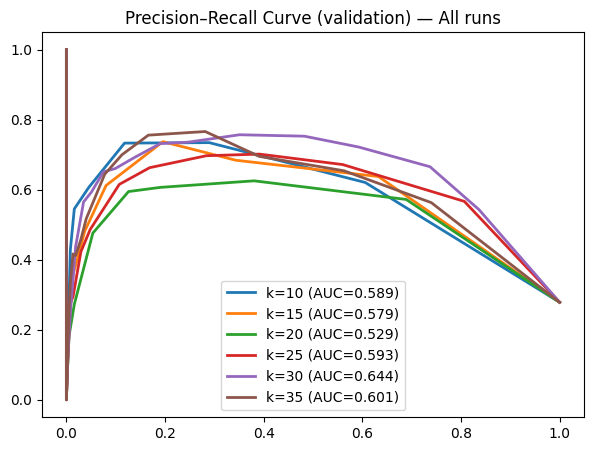

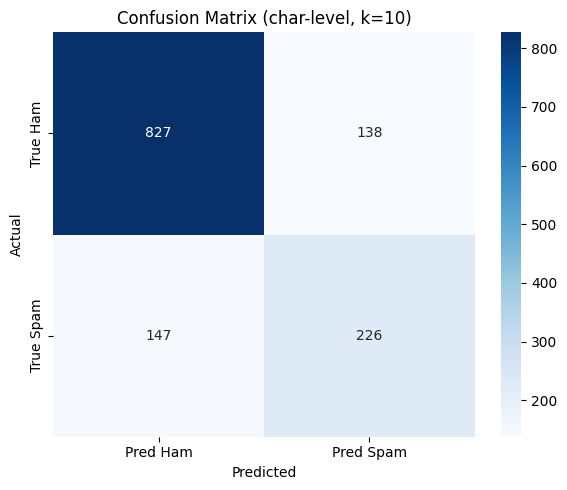

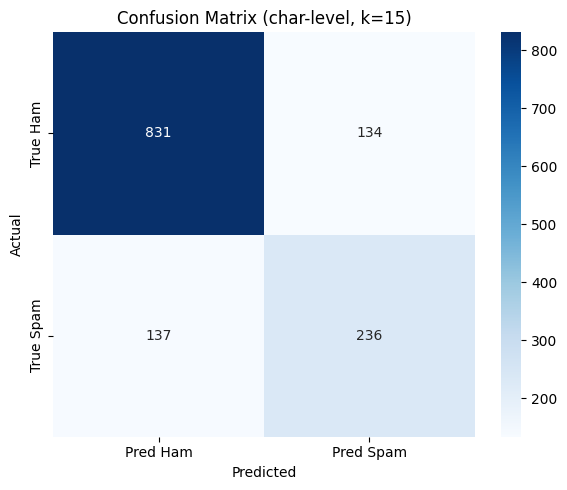

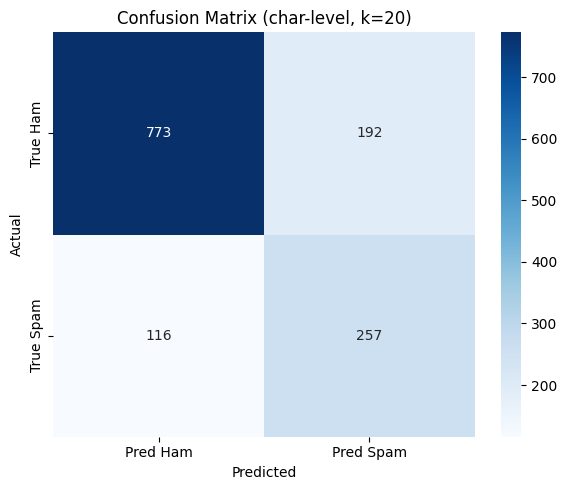

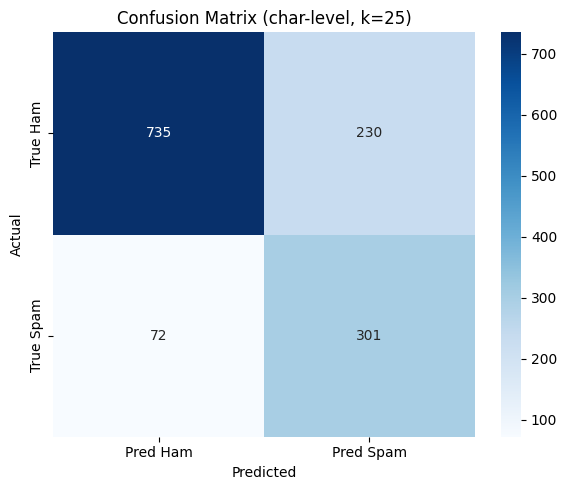

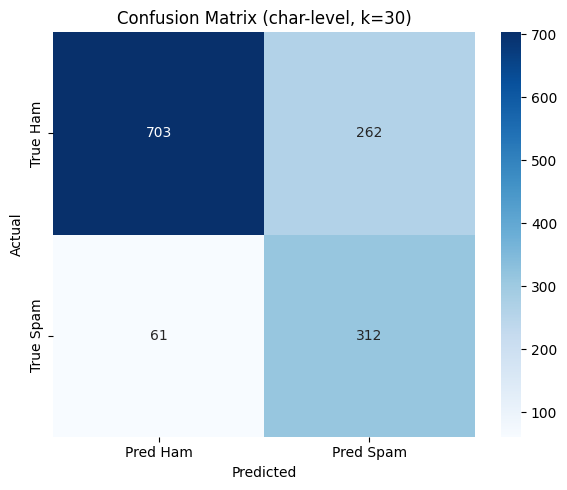

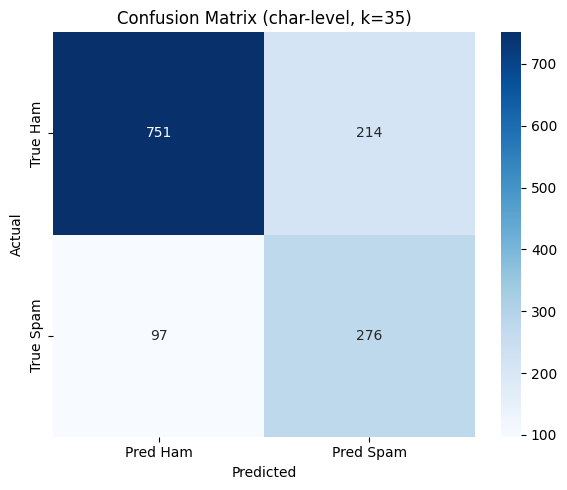

,k,precision,recall,f1,accuracy,pr_auc,detector_coverage,train_runtime,prediction_runtime
0,10,0.620879,0.605898,0.613297,0.786996,0.588793,0.945410,74.281067,0.127687
1,15,0.637838,0.632708,0.635262,0.797459,0.579265,0.984540,111.697863,0.145313
2,20,0.572383,0.689008,0.625304,0.769806,0.528760,0.991970,175.688424,0.175523
3,25,0.566855,0.806971,0.665929,0.774290,0.592802,0.992390,293.346128,0.190469
4,30,0.543554,0.836461,0.658923,0.758595,0.643964,0.989753,374.011811,0.093606
5,35,0.563265,0.739946,0.639629,0.767564,0.600909,0.968420,211.669109,0.051360


In [49]:
# test with different k values
k_values = [10, 15, 20, 25, 30, 35]
fig_pr, ax_pr = plt.subplots(figsize=(7, 5))
results_by_k = []
for k in k_values:
    print(f"\n--- Evaluating with k={k} ---")
    nsa_k = VDetectorNSA_Binary(
        k=k,
        r_min=1, r_max=3,
        max_detectors=5000,
        max_tries=100000,
        sampling="antiprofile",
        random_state=42,
        batch_size=1000
    )
    nsa_k.fit(Xh_train_char_bin)
    train_runtime_k = nsa_k.runtime_
    coverage_k = nsa_k.detector_coverage()
    print(f"Training runtime: {train_runtime_k:.2f} seconds")
    print(f"Detector coverage: {coverage_k:.2%}")

    pred_start = time.time()
    y_pred_k, scores_k = nsa_k.predict(X_eval_char, k_hits=1, return_score=True)
    prediction_runtime_k = time.time() - pred_start
    print(f"Prediction runtime: {prediction_runtime_k:.2f} seconds")

    metrics = evaluate_model(
        y_true=y_eval_char,
        y_pred=y_pred_k,
        scores=scores_k,
        target_names=("ham", "spam"),
        cm_title=f"Confusion Matrix (char-level, k={k})",
        pr_title=f"Precision–Recall Curve (validation, char-level, k={k})",
        pr_ax=ax_pr,
        pr_label=f"k={k}",
        show_pr_legend=False,
        detector_coverage=coverage_k,
        train_runtime=train_runtime_k,
        prediction_runtime=prediction_runtime_k
    )

    summary = {"k": k}
    summary.update({key: val for key, val in metrics.items() if key not in {"classification_report", "confusion_matrix"}})
    results_by_k.append(summary)

# finalize the combined PR plot (show legend once)
ax_pr.set_title("Precision–Recall Curve (validation) — All runs")
ax_pr.legend()
plt.show()  

pd.DataFrame(results_by_k)


it looks like perfomance is getting better with larger detector size but at k = 35 we can see that it did not even manage to hit the max number of detectors producing 4055 detectors that makes 30 more ideal because larger number would require more computational cost from now on .

Therefore, k = 30 represents the optimal detector size, balancing high spam recall, perfect spam precision, and reliable detector generation.

<a class="anchor" id="evaluate"></a>
# Evaluate

Now we will evaluate the final model on the test set using the best hyperparameters found during validation.

Generated 4610 detectors after 100000 tries in 203.65 seconds.
Training runtime (final model): 203.65 seconds
Detector coverage (final model): 98.98%
Prediction runtime (final model): 0.09 seconds
              precision    recall  f1-score   support

         ham       0.91      0.73      0.81       965
        spam       0.53      0.81      0.64       374

    accuracy                           0.75      1339
   macro avg       0.72      0.77      0.72      1339
weighted avg       0.80      0.75      0.76      1339

PR-AUC: 0.583


,precision,recall,f1,accuracy,pr_auc,detector_coverage,train_runtime,prediction_runtime
0,0.532628,0.807487,0.64187,0.74832,0.582988,0.989753,203.649626,0.092639


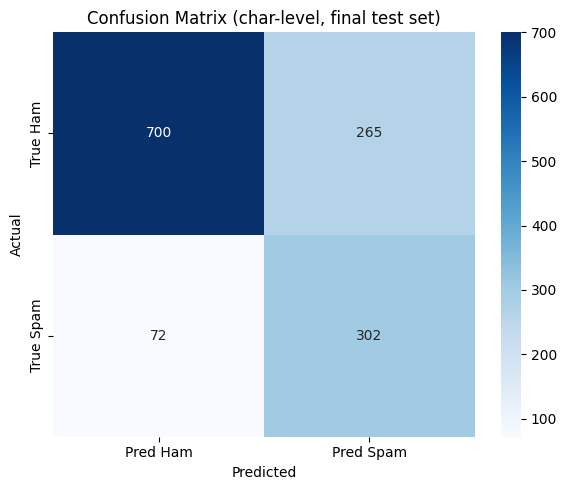

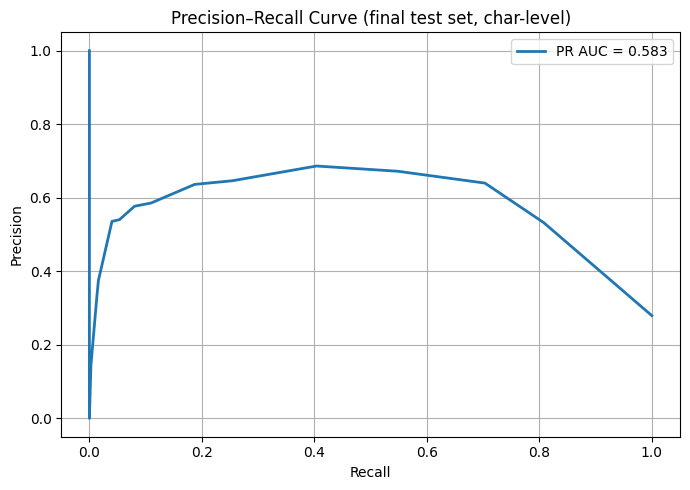

In [61]:
# # Final evaluation on test set with the best model so far
X_test_final = sp.vstack([Xh_test_char_bin, Xs_test_char_bin])
y_test_final = np.hstack([
    np.zeros(Xh_test_char_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_test_char_bin.shape[0], dtype=np.uint8)
])

# train final model
nsa_char_final = VDetectorNSA_Binary(
    k=30,
    r_min=1, r_max=3,
    max_detectors=5000,
    max_tries=100000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
)

nsa_char_final.fit(Xh_train_char_bin)
train_runtime_final = nsa_char_final.runtime_
detector_coverage_final = nsa_char_final.detector_coverage()
print(f"Training runtime (final model): {train_runtime_final:.2f} seconds")
print(f"Detector coverage (final model): {detector_coverage_final:.2%}")

pred_start = time.time()
y_pred_final, scores_final = nsa_char_final.predict(X_test_final, k_hits=1, return_score=True)
prediction_runtime_final = time.time() - pred_start
print(f"Prediction runtime (final model): {prediction_runtime_final:.2f} seconds")

eval_results_final = evaluate_model(
    y_true=y_test_final,
    y_pred=y_pred_final,
    scores=scores_final,
    target_names=("ham", "spam"),
    cm_title="Confusion Matrix (char-level, final test set)",
    pr_title="Precision–Recall Curve (final test set, char-level)",
    detector_coverage=detector_coverage_final,
    train_runtime=train_runtime_final,
    prediction_runtime=prediction_runtime_final
)

pd.DataFrame([
    {k: v for k, v in eval_results_final.items() if k not in {"classification_report", "confusion_matrix"}}
])
